# 이상거래탐지 creditcard 

### 00. 데이터 불러오기

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 원본 데이터셋 creditcard 불러오기

creditcard = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

# df : 보기 쉽게 열 조절한 데이터셋 
df = creditcard.reindex(columns=['Class', 'Time', 'Amount', 
                                 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                                 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                                 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'])
# Class(타겟 변수) 범주화
df['Class']=df['Class'].astype('category')

### 01. 데이터 전처리

In [ ]:
## 처음 행 보존, 중복 행 제거 ##
df.drop_duplicates(keep='first', inplace=True) 

In [ ]:
## 아웃라이어 제거 함수 생성 ##

def remove_outlier (df_cp, column):
    fraud = df_cp[df_cp['Class']== 0][column]
    
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr = iqr * 3

    lowest  = quantile_25 - iqr
    highest = quantile_75 + iqr
    
    outlier_idx = fraud[(fraud < lowest) | (fraud > highest)].index
    print('outlier 개수 :' ,len(outlier_idx))
    
    df_cp.drop(outlier_idx, axis = 0, inplace =True)
    print('shape : ' ,df_cp.shape)
    
    return df_cp   
    return outlier_idx

In [ ]:
## 데이터셋 복사 ##
df1 = df.copy()  # 원 데이터 보존

## df1 V17 outlier 제거 ## 
df1 = remove_outlier(df1, column ='V17')

## df1 V14 outlier 제거 ## 
df1 = remove_outlier(df1, column ='V14')

## df1 V12 outlier 제거 ## 
df1 = remove_outlier(df1, column ='V12')

## df1 V10 outlier 제거 ## 
df1 = remove_outlier(df1, column ='V10')

## df1 V16 outlier 제거 ## 
df1 = remove_outlier(df1, column ='V16')

outlier 개수 : 1093
shape :  (282633, 31)
outlier 개수 : 1625
shape :  (281008, 31)
outlier 개수 : 859
shape :  (280149, 31)
outlier 개수 : 2293
shape :  (277856, 31)
outlier 개수 : 239
shape :  (277617, 31)


### 02. train, test set 분리

In [ ]:
x = df1.iloc[:, 1 :]  
y = df1.iloc[:, 0 ]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 1000)

### 03. train set 샘플링

In [ ]:
pip install imbalanced-learn

In [ ]:
pip install delayed

In [ ]:
from imblearn.combine import SMOTETomek

x_train_st, y_train_st = SMOTETomek(random_state=4).fit_sample(x_train, y_train)

print('SMOTETomek 적용 전 train feature data set: ', x_train.shape, y_train.shape)
print('SMOTETomek 적용 후 train feature data set: ', x_train_st.shape, y_train_st.shape)
print('SMOTETomek 적용 전 label 값 분포: \n', pd.Series(y_train).value_counts())
print('SMOTETomek 적용 후 label 값 분포: \n', pd.Series(y_train_st).value_counts())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTETomek 적용 전 train feature data set:  (194331, 30) (194331,)
SMOTETomek 적용 후 train feature data set:  (386908, 30) (386908,)
SMOTETomek 적용 전 label 값 분포: 
 0    193986
1       345
Name: Class, dtype: int64
SMOTETomek 적용 후 label 값 분포: 
 1    193454
0    193454
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_train_st = pd.DataFrame(x_train_st)
x_train_st.columns = ['Time', 'Amount', 
                                 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                                 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                                 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
y_train_st = pd.DataFrame(y_train_st)
y_train_st.columns = ['Class']

In [ ]:
# 라이브러리 불러오기
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics, model_selection
from sklearn.metrics import classification_report
import statsmodels.api as sm

In [ ]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    
    print('정확도 : {0:2f}, 정밀도 : {1:2f}, 재현율 : {2:2f}'.format(accuracy, precision, recall))
    print('f1-score : {0:2f}, auc : {1:2f}'.format(f1, roc_score))

def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    metrics(y_test,pred)

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
# 하이퍼 파라미터 탐색 함수 생성
def lgbm_cv(learning_rate, num_leaves, max_depth, min_child_weight, colsample_bytree, feature_fraction, bagging_fraction, lambda_l1, lambda_l2):
    model = lgbm.LGBMClassifier(learning_rate=learning_rate,
                                n_estimators = 300,
                                num_leaves = int(round(num_leaves)),
                                max_depth = int(round(max_depth)),
                                min_child_weight = int(round(min_child_weight)),
                                colsample_bytree = colsample_bytree,
                                feature_fraction = max(min(feature_fraction, 1), 0),
                                bagging_fraction = max(min(bagging_fraction, 1), 0),
                                lambda_l1 = max(lambda_l1, 0),
                                lambda_l2 = max(lambda_l2, 0)
                               )
    scoring = {'roc_auc_score': make_scorer(roc_auc_score)}
    result = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    auc_score = result["test_roc_auc_score"].mean()
    return auc_score

In [ ]:
lgbmBO = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 0)
lgbmBO.maximize(init_points=5, n_iter = 5, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8435   |  0.5434   |  0.708    |  0.5968   |  0.5394   |  0.4194   |  0.03584  |  12.06    |  92.42    |  589.1    |
|  2        |  0.8855   |  0.3797   |  0.7838   |  0.5237   |  0.5624   |  0.9163   |  0.01284  |  4.004    |  31.42    |  549.8    |
|  3        |  0.871    |  0.7704   |  0.8613   |  0.9688   |  0.7912   |  0.4569   |  0.04122  |  4.72     |  74.79    |  343.0    |
|  4        |  0.8986   |  0.9352   |  0.5166   |  0.4106   |  0.2619   |  0.7665   |  0.02825  |  15.07    |  31.32    |  485.3    |
|  5        |  0.8971   |  0.606    |  0.6108   |  0.9343   |  0.675    |  0.3559   |  0.02748  |  18.05    |  34.22    |  500.0    |
|  6        |  0.7928   |  0.2534   |  0.2244   |  0.05377  | 

In [ ]:
fit_lgbm = lgbm.LGBMClassifier(learning_rate=lgbmBO.max['params']['learning_rate'],
                               num_leaves = int(round(lgbmBO.max['params']['num_leaves'])),
                               max_depth = int(round(lgbmBO.max['params']['max_depth'])),
                               min_child_weight = int(round(lgbmBO.max['params']['min_child_weight'])),
                               colsample_bytree=lgbmBO.max['params']['colsample_bytree'],
                               feature_fraction = max(min(lgbmBO.max['params']['feature_fraction'], 1), 0),
                               bagging_fraction = max(min(lgbmBO.max['params']['bagging_fraction'], 1), 0),
                               lambda_l1 = lgbmBO.max['params']['lambda_l1'],
                               lambda_l2 = lgbmBO.max['params']['lambda_l2']
                               )

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
y_train_st

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
fit_lgbm.fit(x_train,y_train)
y_pred = fit_lgbm.predict(x_test)
print(classification_report(y_test, y_pred))
accuracy=accuracy_score(y_pred, y_test)
# 정확도 확인
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
# 과적합 확인
print('Train set score: {:.4f}'.format(fit_lgbm.score(x_train, y_train)))
print('Test set score: {:.4f}'.format(fit_lgbm.score(x_test, y_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83158
           1       1.00      0.81      0.90       128

    accuracy                           1.00     83286
   macro avg       1.00      0.91      0.95     83286
weighted avg       1.00      1.00      1.00     83286

LightGBM Model accuracy score: 0.9997
Train set score: 0.9996
Test set score: 0.9997


In [ ]:
# 하이퍼 파라미터 탐색 함수 생성
def lgbm_cv(learning_rate, num_leaves, max_depth, min_child_weight, colsample_bytree, feature_fraction, bagging_fraction, lambda_l1, lambda_l2):
    model = lgbm.LGBMClassifier(learning_rate=learning_rate,
                                n_estimators = 300,
                                num_leaves = int(round(num_leaves)),
                                max_depth = int(round(max_depth)),
                                min_child_weight = int(round(min_child_weight)),
                                colsample_bytree = colsample_bytree,
                                feature_fraction = max(min(feature_fraction, 1), 0),
                                bagging_fraction = max(min(bagging_fraction, 1), 0),
                                lambda_l1 = max(lambda_l1, 0),
                                lambda_l2 = max(lambda_l2, 0)
                               )
    scoring = {'roc_auc_score': make_scorer(roc_auc_score)}
    result = cross_validate(model, x_train_st, y_train_st, cv=5, scoring=scoring)
    auc_score = result["test_roc_auc_score"].mean()
    return auc_score

In [ ]:
lgbmBO = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 0)
lgbmBO.maximize(init_points=5, n_iter = 5, acq='ei', xi=0.01)

In [ ]:
lgbm.fit(x_train_st,y_train_st)
y_pred = lgbm.predict(x_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83158
           1       0.88      0.88      0.88       128

    accuracy                           1.00     83286
   macro avg       0.94      0.94      0.94     83286
weighted avg       1.00      1.00      1.00     83286



### 04. train set 데이터 시각화 + 전처리

In [ ]:
## 글꼴설정
import matplotlib as mpl
import matplotlib.pylab as plt

# 한글깨짐 해결
plt.rcParams["font.family"] = "NanumGothic"

# 마이너스 깨짐 해결
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
train_st = pd.concat([y_train_st, x_train_st], axis=1)

In [ ]:
## 상관관계 확인 ##
corr= train_st.corr()
corr.sort_values(by='Class', ascending=True) # 타겟변수와 상관관계 높은 순

## 17, 14, 12, 10, 16 -> 이상치 이미 제거됨 ##

,Class,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
V14,-0.786637,0.195020,0.034042,0.487877,-0.609388,0.693418,-0.834787,0.449488,0.579104,0.612603,-0.281957,0.740461,0.821362,-0.893802,0.901551,-0.056518,1.000000,0.018134,0.805011,0.757630,0.651896,-0.386695,-0.195935,-0.250197,0.011799,0.057319,0.136781,-0.040617,-0.176512,-0.220064,-0.124110
V12,-0.697422,0.294843,0.025111,0.608448,-0.693507,0.771116,-0.857716,0.598276,0.536734,0.762233,-0.255808,0.793471,0.905943,-0.907751,1.000000,-0.128189,0.901551,0.074931,0.902015,0.874474,0.796443,-0.454876,-0.248885,-0.140609,-0.095422,0.043104,0.077025,0.052366,-0.138885,-0.085253,-0.019834
V10,-0.661351,0.262543,-0.008089,0.735772,-0.772014,0.848648,-0.829729,0.726420,0.501954,0.875729,-0.216353,0.842705,1.000000,-0.839544,0.905943,-0.108561,0.821362,0.104726,0.882700,0.877849,0.817614,-0.454128,-0.379269,0.019922,-0.152105,0.015298,0.037051,0.024099,-0.075850,-0.000228,0.093594
V16,-0.612048,0.279887,-0.020010,0.655014,-0.650242,0.740863,-0.767323,0.681788,0.482987,0.785542,-0.324550,0.776457,0.882700,-0.822214,0.902015,-0.157276,0.805011,-0.007877,1.000000,0.952663,0.902480,-0.625435,-0.214056,-0.188382,-0.116634,0.053970,-0.005020,0.080718,-0.096190,-0.088323,0.019460
V9,-0.589301,0.189741,0.002685,0.660701,-0.705684,0.762276,-0.800001,0.645043,0.434763,0.778905,-0.212300,1.000000,0.842705,-0.735684,0.793471,-0.093916,0.740461,0.064994,0.776457,0.796417,0.743066,-0.400167,-0.357831,0.066592,-0.161087,0.000837,0.028038,-0.002300,-0.145492,-0.013603,0.105099
V3,-0.588310,0.169567,-0.029493,0.867165,-0.859314,1.000000,-0.780373,0.835704,0.542929,0.891713,-0.405801,0.762276,0.848648,-0.732251,0.771116,-0.123152,0.693418,0.110256,0.740863,0.752602,0.708973,-0.343652,-0.371492,-0.021646,0.004890,0.054020,0.028859,-0.106352,-0.044553,-0.034516,0.069495
V17,-0.572966,0.281170,-0.023080,0.703944,-0.663331,0.752602,-0.746001,0.743005,0.467646,0.816122,-0.367967,0.796417,0.877849,-0.786909,0.874474,-0.173032,0.757630,0.006937,0.952663,1.000000,0.936872,-0.617146,-0.217745,-0.166489,-0.107960,0.055777,-0.038784,0.056387,-0.080570,-0.070402,0.063209
V7,-0.501688,0.271191,0.095740,0.874307,-0.823643,0.891713,-0.744206,0.839921,0.416982,1.000000,-0.212901,0.778905,0.875729,-0.690411,0.762233,-0.120729,0.612603,0.127886,0.785542,0.816122,0.793027,-0.415836,-0.397969,0.092277,-0.123530,0.047860,-0.018883,0.029105,-0.022474,0.086015,0.134208
V18,-0.473999,0.310043,-0.018139,0.691791,-0.628240,0.708973,-0.672462,0.738450,0.408785,0.793027,-0.349771,0.743066,0.817614,-0.693010,0.796443,-0.177412,0.651896,-0.006708,0.902480,0.936872,1.000000,-0.584987,-0.188628,-0.126512,-0.108556,0.072391,-0.063224,0.075604,-0.060133,-0.024882,0.105028
V6,-0.464989,0.138768,0.163674,0.425445,-0.413398,0.542929,-0.491637,0.365445,1.000000,0.416982,-0.508386,0.434763,0.501954,-0.537800,0.536734,-0.070671,0.579104,-0.025400,0.482987,0.467646,0.408785,-0.215873,-0.116165,-0.209345,0.172894,0.233857,0.016661,-0.158916,-0.056717,-0.215668,-0.083841


In [ ]:
## 데이터셋 복사 ##
train_st1 = train_st.copy()  # 원 데이터 보존

## df1 V4 outlier 제거 ## -> 변화가 없;;
train_st1 = remove_outlier(train_st1, column ='V4')

## df1 V11 outlier 제거 ## -> 아웃라이어가 없...
train_st1 = remove_outlier(train_st1, column ='V11')

## df1 V9 outlier 제거 ## -> 딱히 변화 없... 오히려 떨어짐
train_st1 = remove_outlier(train_st1, column ='V9')

## df1 V3 outlier 제거 ## -> 이거도 성능이 떨어짐...ㅠㅠㅣ;;';
train_st1 = remove_outlier(train_st1, column ='V3')

x_train_st1 = train_st1.drop(['Class'], axis=1)
y_train_st1 = train_st1['Class']

outlier 개수 : 126
shape :  (386782, 31)
outlier 개수 : 0
shape :  (386782, 31)
outlier 개수 : 53
shape :  (386729, 31)
outlier 개수 : 72
shape :  (386657, 31)


In [ ]:
lgbm.fit(x_train_st1,y_train_st1)
y_pred = lgbm.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83158
           1       0.86      0.88      0.87       128

    accuracy                           1.00     83286
   macro avg       0.93      0.94      0.94     83286
weighted avg       1.00      1.00      1.00     83286



<Figure size 432x288 with 0 Axes>

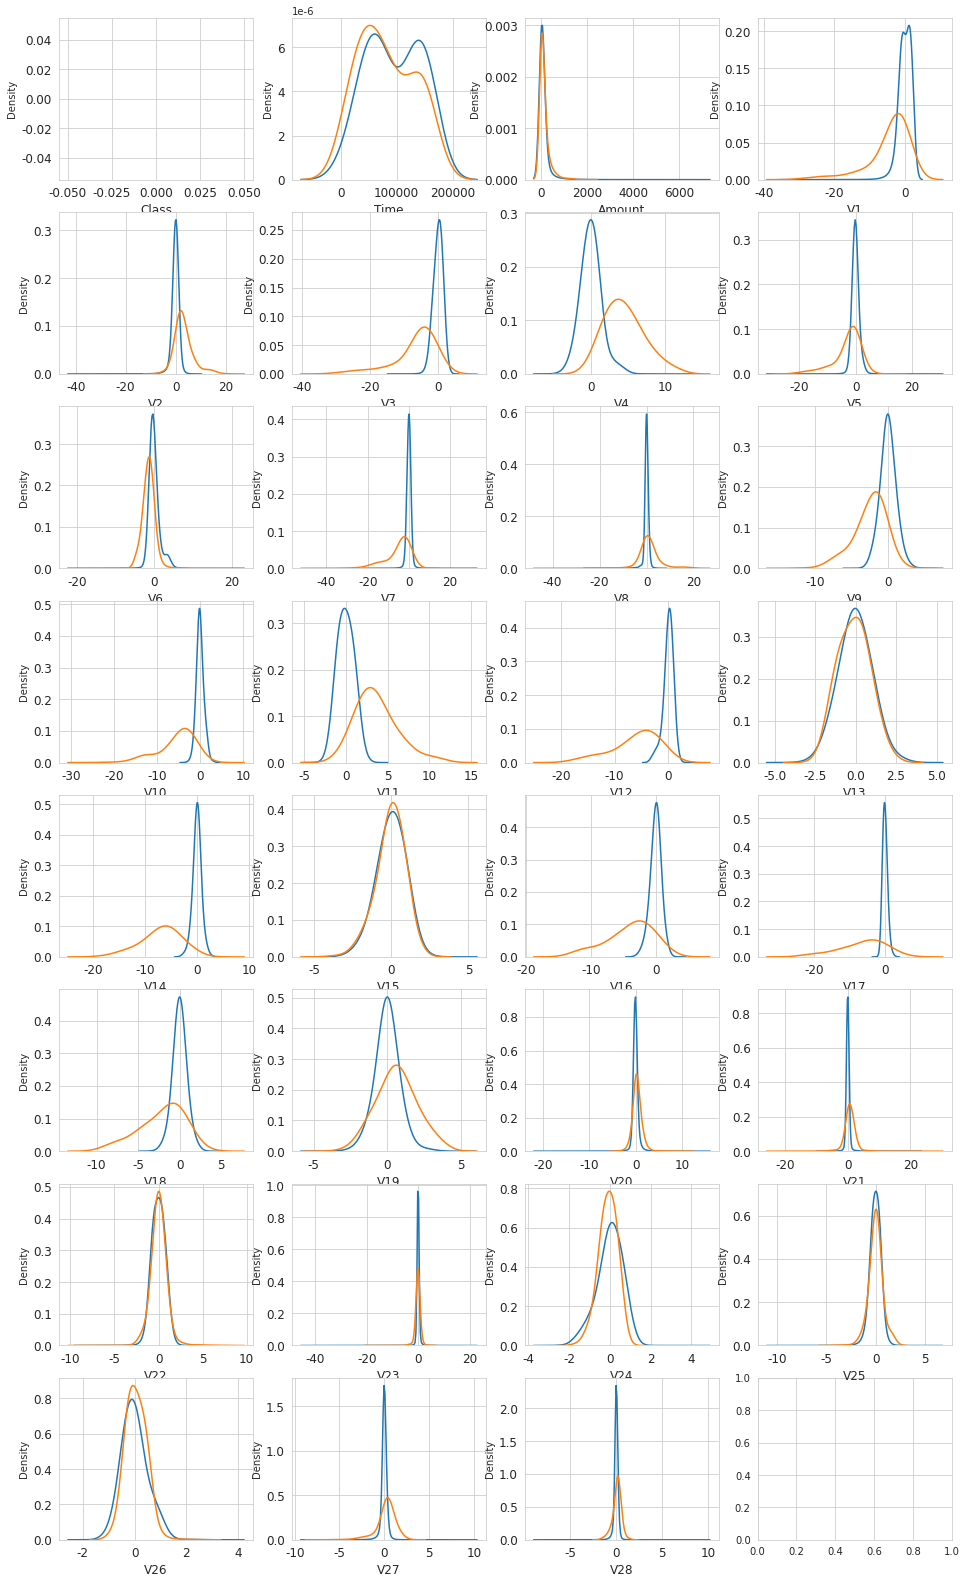

In [ ]:
var = train_st.columns.values

i = 0
t0 = train_st.loc[train_st['Class'] == 0]
t1 = train_st.loc[train_st['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [ ]:
## 다중공선성 ##
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_st.values, i) for i in range(train_st.shape[1])]
vif["features"] = train_st.columns
vif

,VIF Factor,features
0,6.366006,Class
1,3.000350,Time
2,11.413399,Amount
3,12.769830,V1
4,24.312153,V2
5,23.185978,V3
6,11.191929,V4
7,27.235558,V5
8,3.816980,V6
9,61.291717,V7


1. VIF 계수가 높은 feature제거

2. 단 유사한 feature의 경우, 둘 중 1개만 제거(FIP, kFIP의 경우)

3. 제거 후 VIF계수 재출력

4. (1, 2, 3)의 과정 반복

5. 회귀분석 진행

6. feature의 p-value점검

In [ ]:
train_st=train_st.drop(['V7','V17','V12','V10','V14','V16','V3','V2'], axis=1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_st.values, i) for i in range(train_st.shape[1])]
vif["features"] = train_st.columns
vif.sort_values(by='VIF Factor', ascending=False).head()

,VIF Factor,features
4,7.807876,V4
9,6.893389,V11
5,6.819086,V5
8,5.742282,V9
3,5.672621,V1


In [ ]:
vif

,VIF Factor,features
0,5.501225,Class
1,1.867641,Time
2,1.760448,Amount
3,5.672621,V1
4,7.807876,V4
5,6.819086,V5
6,2.598903,V6
7,2.446287,V8
8,5.742282,V9
9,6.893389,V11


In [ ]:
x_train_st = train_st1.drop(['Class'], axis=1)
y_train_st = train_st1['Class']

In [ ]:
lgbm.fit(x_train_st,y_train_st)
y_pred = lgbm.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83158
           1       0.86      0.88      0.87       128

    accuracy                           1.00     83286
   macro avg       0.93      0.94      0.94     83286
weighted avg       1.00      1.00      1.00     83286



## 04. 스케일링

In [ ]:
## 스케일링

from sklearn.preprocessing import RobustScaler

x_train_st = train_st1.drop(['Class'], axis=1)
y_train_st = train_st1['Class']

In [ ]:
## Amount 스케일링 ##
pd.set_option('mode.chained_assignment',  None)

# RobustScaler
ro = RobustScaler() 
x_train_st['Amount_robust'] = ro.fit_transform(x_train_st['Amount'].values.reshape(-1,1))


## Time 스케일링 ##

# RobustScaler
rc = RobustScaler() 
x_train_st['Time_robust'] = rc.fit_transform(x_train_st['Time'].values.reshape(-1,1))

In [ ]:
## Amount, Time 삭제 ##
x_train_st = x_train_st.reindex(columns=[ 'Amount_robust', 'Time_robust', 
                                 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                                 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                                 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'])

In [ ]:
import lightgbm as lgbm
fit_lgbm = lgbm.LGBMClassifier(bagging_fraction=0.6995196530726653, boosting_type='gbdt',
               class_weight=None, colsample_bytree=0.8154730273989589,
               feature_fraction=0.47637206677334143, importance_type='split',
               lambda_l1=0.3784541644450563, lambda_l2=0.8067472771124881,
               learning_rate=0.04311120781400105, max_depth=11,
               min_child_samples=20, min_child_weight=30, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=301, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
fit_lgbm.fit(x_train_st,y_train_st)
y_pred = fit_lgbm.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83158
           1       0.77      0.88      0.82       128

    accuracy                           1.00     83286
   macro avg       0.88      0.94      0.91     83286
weighted avg       1.00      1.00      1.00     83286



## 05. LGBM

In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=e5efc911fd57415a1ebb699cb904d261c923bd2e9d2f72940f4f0040136864c3
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
# 라이브러리 불러오기
import lightgbm as lgbm
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score, make_scorer, f1_score
from sklearn.model_selection import cross_validate

In [ ]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label().astype(int)
    y_hat = np.round(y_hat).astype(int) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat, average='weighted'), True

In [ ]:
# 하이퍼 파라미터 탐색 함수 생성
def lgbm_cv(learning_rate, num_leaves, max_depth, min_child_weight, colsample_bytree, feature_fraction, bagging_fraction, lambda_l1, lambda_l2):
    model = lgbm.LGBMClassifier(learning_rate=learning_rate,
                                n_estimators = 300,
                                num_leaves = int(round(num_leaves)),
                                max_depth = int(round(max_depth)),
                                min_child_weight = int(round(min_child_weight)),
                                colsample_bytree = colsample_bytree,
                                feature_fraction = max(min(feature_fraction, 1), 0),
                                bagging_fraction = max(min(bagging_fraction, 1), 0),
                                lambda_l1 = max(lambda_l1, 0),
                                lambda_l2 = max(lambda_l2, 0)
                               )
    scoring = {'f1_score': make_scorer(f1_score)}
    result = cross_validate(model, x_train_smote, y_train_smote, cv=5, scoring=scoring)
    f1_score = result["test_f1_score"].mean()
    return f1_score

In [ ]:
# 파라미터 탐색 구간
pbounds = {'learning_rate' : (0.01, 0.05),
           'num_leaves': (300, 600),
           'max_depth': (2, 25),
           'min_child_weight': (30, 100),
           'colsample_bytree': (0, 0.99),
           'feature_fraction': (0.0001, 0.99),
           'bagging_fraction': (0.0001, 0.99),
           'lambda_l1' : (0, 0.99),
           'lambda_l2' : (0, 0.99),
          }

In [ ]:
# 랜덤 파라미터 생성
lgbmBO = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 207)
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9999   |  0.498    |  0.3624   |  0.4429   |  0.3583   |  0.6293   |  0.03159  |  10.02    |  31.15    |  462.4    |
|  2        |  0.9882   |  0.02598  |  0.09748  |  0.8384   |  0.8219   |  0.8749   |  0.03358  |  2.708    |  71.37    |  354.7    |
|  3        |  0.9977   |  0.6211   |  0.1951   |  0.2552   |  0.9724   |  0.3936   |  0.0318   |  5.403    |  76.39    |  584.1    |
|  4        |  0.9779   |  0.6027   |  0.9031   |  0.05214  |  0.9324   |  0.08896  |  0.04567  |  19.94    |  48.58    |  403.8    |
|  5        |  0.9964   |  0.4734   |  0.1796   |  0.08379  |  0.5865   |  0.7819   |  0.023    |  16.41    |  30.72    |  547.4    |
|  6        |  0.9854   |  0.1841   |  0.2571   |  0.7683   | 

In [ ]:
# max 파라미터
lgbmBO.max

{'params': {'bagging_fraction': 0.6995196530726653,
  'colsample_bytree': 0.8154730273989589,
  'feature_fraction': 0.47637206677334143,
  'lambda_l1': 0.3784541644450563,
  'lambda_l2': 0.8067472771124881,
  'learning_rate': 0.04311120781400105,
  'max_depth': 11.324101657707663,
  'min_child_weight': 30.488952637035492,
  'num_leaves': 301.14586150787403},
 'target': 0.9999123648231091}

In [ ]:
# lgbm 모델 생성
fit_lgbm = lgbm.LGBMClassifier(learning_rate=lgbmBO.max['params']['learning_rate'],
                               num_leaves = int(round(lgbmBO.max['params']['num_leaves'])),
                               max_depth = int(round(lgbmBO.max['params']['max_depth'])),
                               min_child_weight = int(round(lgbmBO.max['params']['min_child_weight'])),
                               colsample_bytree=lgbmBO.max['params']['colsample_bytree'],
                               feature_fraction = max(min(lgbmBO.max['params']['feature_fraction'], 1), 0),
                               bagging_fraction = max(min(lgbmBO.max['params']['bagging_fraction'], 1), 0),
                               lambda_l1 = lgbmBO.max['params']['lambda_l1'],
                               lambda_l2 = lgbmBO.max['params']['lambda_l2']
                               )

fit_lgbm.fit(x_train_smote,y_train_smote)

LGBMClassifier(bagging_fraction=0.6995196530726653, boosting_type='gbdt',
               class_weight=None, colsample_bytree=0.8154730273989589,
               feature_fraction=0.47637206677334143, importance_type='split',
               lambda_l1=0.3784541644450563, lambda_l2=0.8067472771124881,
               learning_rate=0.04311120781400105, max_depth=11,
               min_child_samples=20, min_child_weight=30, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=301, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
fit_lgbm = lgbm.LGBMClassifier(bagging_fraction=0.6995196530726653, boosting_type='gbdt',
               class_weight=None, colsample_bytree=0.8154730273989589,
               feature_fraction=0.47637206677334143, importance_type='split',
               lambda_l1=0.3784541644450563, lambda_l2=0.8067472771124881,
               learning_rate=0.04311120781400105, max_depth=11,
               min_child_samples=20, min_child_weight=30, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=301, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

fit_lgbm.fit(x_train_st,y_train_st)

LGBMClassifier(bagging_fraction=0.6995196530726653, boosting_type='gbdt',
               class_weight=None, colsample_bytree=0.8154730273989589,
               feature_fraction=0.47637206677334143, importance_type='split',
               lambda_l1=0.3784541644450563, lambda_l2=0.8067472771124881,
               learning_rate=0.04311120781400105, max_depth=11,
               min_child_samples=20, min_child_weight=30, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=301, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
y_pred=fit_lgbm.predict(x_test)
accuracy=accuracy_score(y_pred, y_test)
# 정확도 확인
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
# 과적합 확인
print('Train set score: {:.4f}'.format(fit_lgbm.score(x_train_smote, y_train_smote)))
print('Test set score: {:.4f}'.format(fit_lgbm.score(x_test, y_test)))

LightGBM Model accuracy score: 0.9995
Train set score: 0.9999
Test set score: 0.9995


In [ ]:
y_pred=fit_lgbm.predict(x_test)
accuracy=accuracy_score(y_pred, y_test)
# 정확도 확인
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
# 과적합 확인
print('Train set score: {:.4f}'.format(fit_lgbm.score(x_train_st, y_train_st)))
print('Test set score: {:.4f}'.format(fit_lgbm.score(x_test, y_test)))

LightGBM Model accuracy score: 0.9995
Train set score: 0.9999
Test set score: 0.9995


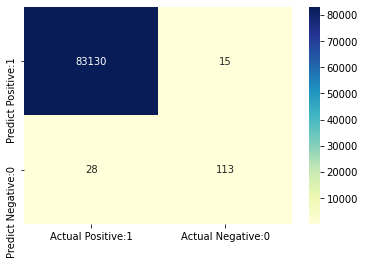

In [ ]:
cm = confusion_matrix(y_pred, y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83158
           1       0.80      0.88      0.84       128

    accuracy                           1.00     83286
   macro avg       0.90      0.94      0.92     83286
weighted avg       1.00      1.00      1.00     83286



In [ ]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83158
           1       0.75      0.88      0.81       128

    accuracy                           1.00     83286
   macro avg       0.87      0.94      0.90     83286
weighted avg       1.00      1.00      1.00     83286

